# Testing FOOOF with Synthetic Data

Words, words, words.

ToDo:
    - Update freqs & probs from MEG data
Decision:
    - absolute deviation, plot the distributions.
    
- Go to 1000 PSDs

In [116]:
%matplotlib inline

from collections import Counter

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import sem

from fooof import FOOOF, FOOOFGroup, fit_fooof_group_3d
from fooof.synth import gen_power_spectrum, gen_group_power_spectra, param_sampler
#from fooof.analysis import get_band_peak_group

In [2]:
from syn_utils import *
from syn_plts import *

In [3]:
import random
random.seed(999)

In [4]:
sns.set_style('white')

## Check Generation

In [ ]:
# Test generate a power spectrum
f_range = [3, 40]
bg = [0, 1]
osc = [10, 0.5, 2]
nlv = 0.
freq_res = 0.25

fs, ps = gen_power_spectrum(f_range, bg, osc, nlv, freq_res)

In [ ]:
# Plot example synthesized power spectrum
plt.plot(fs, ps)

In [ ]:
fm = FOOOF()
fm.report(fs, ps, plt_log=False)

In [ ]:
# Compare actual parameters to FOOOF fit
print(bg, '\t', fm.background_params_)
print(osc, '\t', fm._gaussian_params)

## Synthetic Generation Settings

Settings defined in syn_utils - check them. 

In [ ]:
print_settings(N_OSCS_OPTS, N_OSCS_PROBS, '# of oscs')

In [ ]:
print_settings(CF_OPTS, CF_PROBS, 'CFs')

In [ ]:
print_settings(AMP_OPTS, AMP_PROBS, 'AMPs')

In [ ]:
print_settings(BW_OPTS, BW_PROBS, 'BWs')

In [ ]:
print_settings(OFF_OPTS, OFF_PROBS, 'background offset')

In [ ]:
print_settings(SL_OPTS, SL_PROBS, 'background slope')

In [ ]:
# Sanity check probabilities are set correctly
for probs in [CF_PROBS, AMP_PROBS, BW_PROBS, OFF_PROBS, SL_PROBS]:
    assert np.isclose(sum(probs), 1, 1e-10)
print('All probabilities check out.')

### Fitting Oscillations: 1 Oscillation Across Noise Levels

In [ ]:
# Settings for PSD generation
f_range = [3, 40]
f_res = 0.25

# Set the number of PSDs - this is per noise condition
n_psds = 10

# Set the noise levels to use
nlvs = [0.0, 0.025, 0.050, 0.10, 0.15]

# Use generators to sample peak & background parameters
peaks = gen_osc_def(1)
bgs = gen_bg_def()

In [ ]:
# Get data sizes
n_nlvs = len(nlvs)
n_freqs = int((f_range[1] - f_range[0]) / f_res + 1)

In [ ]:
# Generate power spectra
freqs = np.empty(shape=n_freqs)
psds = np.empty(shape=[n_nlvs, n_psds, n_freqs])
syn_params = [None] * n_nlvs

for n_ind, nlv in enumerate(nlvs):
    freqs, psds[n_ind, :, :], syn_params[n_ind] = gen_group_power_spectra(n_psds, f_range, bgs, peaks, nlv, 0.25)
    
# Check shape
print('n_nlvs, n_spectra, n_freqs : ', psds.shape)

In [ ]:
# Extract ground truth values
osc_truths, bg_truths = get_ground_truth(syn_params)

In [ ]:
# Initialize FOOOFGroup to test with
fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6)

# Fit power spectra - same FOOOF settings across each group of synthetic power spectra
fgs = fit_fooof_group_3d(fg, freqs, psds)

In [ ]:
# # Alternatively:
# # Fit power spectra - adapting FOOOF settings for each group of synthetic power spectra
# fgs = []
# for nlv, nlv_psds in zip(nlvs, psds):
#     fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, min_peak_amplitude=5*nlv)
#     fg.fit(freqs, nlv_psds)
#     fgs.append(fg.copy())

In [ ]:
# Extract data of interest from FOOOF fits
osc_fits, bg_fits, err_fits, r2_fits, n_oscs = get_fit_data(fgs)

In [ ]:
# Calculate error
osc_errors = np.abs(osc_truths - osc_fits) # absolute deviation
bg_errors = np.abs(bg_truths - bg_fits)

#osc_errors = (osc_truths - osc_fits)**2   # squared error
#bg_errors = (bg_truths - bg_fits)**2

In [ ]:
# Pull out error per oscillations parameter
cf_errors = osc_errors[:, :, 0]
amp_errors = osc_errors[:, :, 1]
bw_errors = osc_errors[:, :, 2]

# Pull out error per background parameter
off_errors = bg_errors[:, :, 0]
sl_errors = bg_errors[:, :, 1]

In [ ]:
# Plot Settings
#avg = 'mean'
#avg = 'median'
#err = 'sem'

In [ ]:
#plot_errors(cf_errors, 'CF', avg, err)
plot_errors_violin(cf_errors, 'CF')
#plt.ylim([-0.5, 5])

In [ ]:
#plot_errors(amp_errors, 'Amp', avg, err)
plot_errors_violin(amp_errors, 'Amp')

In [ ]:
#plot_errors(bw_errors, 'BW', avg, err)
plot_errors_violin(bw_errors, 'BW')

In [ ]:
#plot_errors(off_errors, 'Off', avg, err)
plot_errors_violin(off_errors, 'Off')

In [ ]:
#plot_errors(sl_errors, 'Sl', avg, err)
plot_errors_violin(sl_errors, 'Sl')

In [ ]:
#plot_errors(err_fits, 'Error', avg, err)
plot_errors_violin(err_fits)

In [ ]:
#plot_errors(r2_fits, 'R2', avg, err)
plot_errors_violin(r2_fits, 'R2')

In [ ]:
#plot_errors(n_oscs, 'N Oscillations')
plot_errors_violin(n_oscs, 'N Oscillations')

In [ ]:
# Grab example cases - low noise
ind = 0
fm_nlv1 = fgs[0].get_fooof(ind, True)
print(syn_params[0][ind])
fm_nlv1.print_results()
fm_nlv1.plot()

In [ ]:
# Grab example cases - high noise
ind = 0
fm_nlv5 = fgs[-1].get_fooof(ind, True)
print(syn_params[-1][ind])
fm_nlv5.print_results()
fm_nlv5.plot()

## Check error for multiple peaks

In [37]:
# Settings for PSD generation
f_range = [3, 40]
f_res = 0.25

# Set the number of PSDs - this is per n_osc condition
n_psds = 100

# Set the noise levels to use
n_oscs = [0, 1, 2, 3, 4]
nlv = 0.01
#nlvs = [0.0, 0.025, 0.050, 0.10, 0.15]

# Use generators to sample peak & background parameters
peaks = []
for n_osc in n_oscs:
    peaks.append(gen_osc_def(n_osc))
bgs = gen_bg_def()

In [38]:
# Get data sizes
n_n_oscs = len(n_oscs)
n_freqs = int((f_range[1] - f_range[0]) / f_res + 1)

In [39]:
# Generate power spectra
freqs = np.empty(shape=n_freqs)
psds = np.empty(shape=[n_n_oscs, n_psds, n_freqs])
syn_params = [None] * n_n_oscs

#for n_ind, n_osc in enumerate(n_oscs):
for n_ind, n_osc, peaks in zip(range(n_n_oscs), n_oscs, peaks):
    freqs, psds[n_ind, :, :], syn_params[n_ind] = gen_group_power_spectra(n_psds, f_range, bgs, peaks, nlv, 0.25)
    
# Check shape
print('n_nlvs, n_spectra, n_freqs : ', psds.shape)

n_nlvs, n_spectra, n_freqs :  (5, 100, 149)


In [40]:
# Extract ground truth values
peak_truths, bg_truths = get_ground_truth(syn_params)

In [41]:
# Initialize FOOOFGroup to test with
fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, min_peak_amplitude=0.075)

# Fit power spectra - same FOOOF settings across each group of synthetic power spectra
fgs = fit_fooof_group_3d(fg, freqs, psds)

In [42]:
# Extract data of interest from FOOOF fits
_, bg_fits, err_fits, r2_fits, n_fit_oscs = get_fit_data(fgs)

# Calculate error
bg_errors = np.abs(bg_truths - bg_fits)

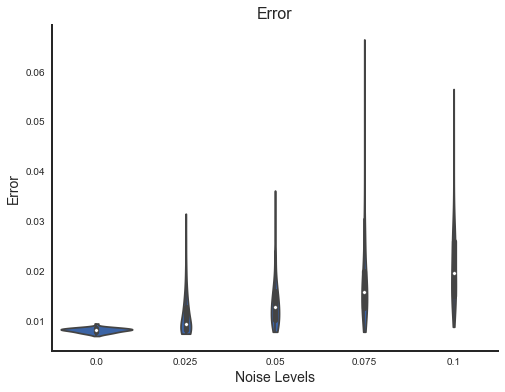

In [43]:
plot_errors_violin(err_fits, 'Error')

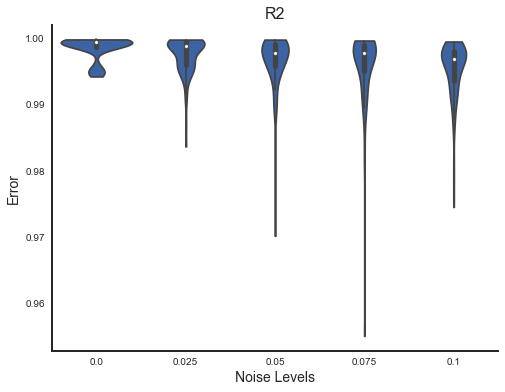

In [44]:
plot_errors_violin(r2_fits, 'R2')

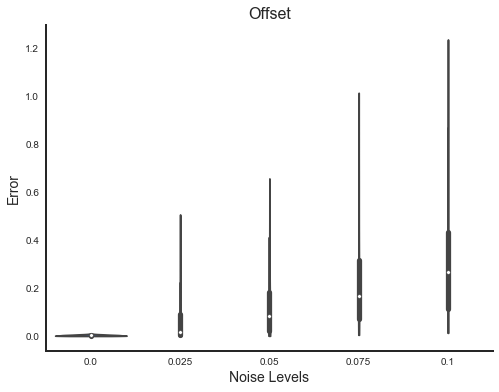

In [45]:
plot_errors_violin(bg_errors[:, :, 0], 'Offset')

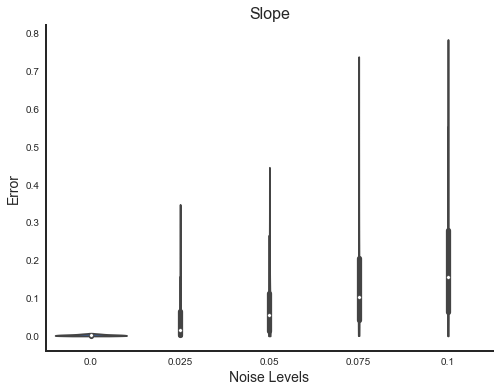

In [46]:
plot_errors_violin(bg_errors[:, :, 1], 'Slope')

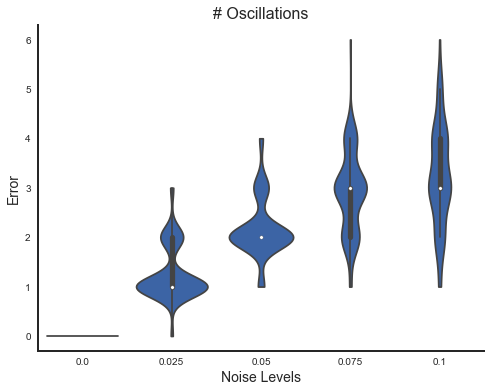

In [47]:
plot_errors_violin(n_fit_oscs, '# Oscillations')

In [74]:
#
n_actual_oscillations = []
for n in n_oscs:
    n_actual_oscillations.append([n] * n_psds)
n_actual_oscillations = np.array(n_actual_oscillations)
n_actual_oscillations = n_actual_oscillations.flatten()

#
n_fit_oscs = n_fit_oscs.flatten()

In [113]:
dat = []
for a, b in zip(n_actual_oscillations, n_fit_oscs):
    dat.append((a, b))
cc = Counter(dat)

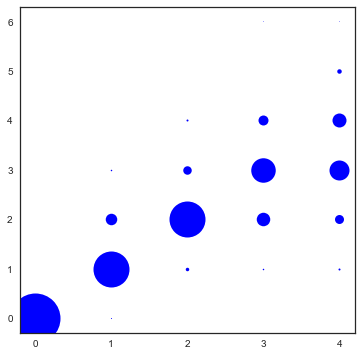

In [114]:
fig = plt.figure(figsize=[6, 6])
for ke, va in cc.items():
    plt.plot(ke[0], ke[1], '.', markersize=va, color='blue')
plt.xticks(list(range(0, 5)), list(range(0, 5)));

SynParams(background_params=[0, 1.0], gaussian_params=[10, 0.20000000000000001, 1.5, 24, 0.14999999999999999, 1.5, 16, 0.25, 4.0, 21, 0.5, 1.5], nlv=0.01)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                          0.0275, 1.0125                                          
                                                     

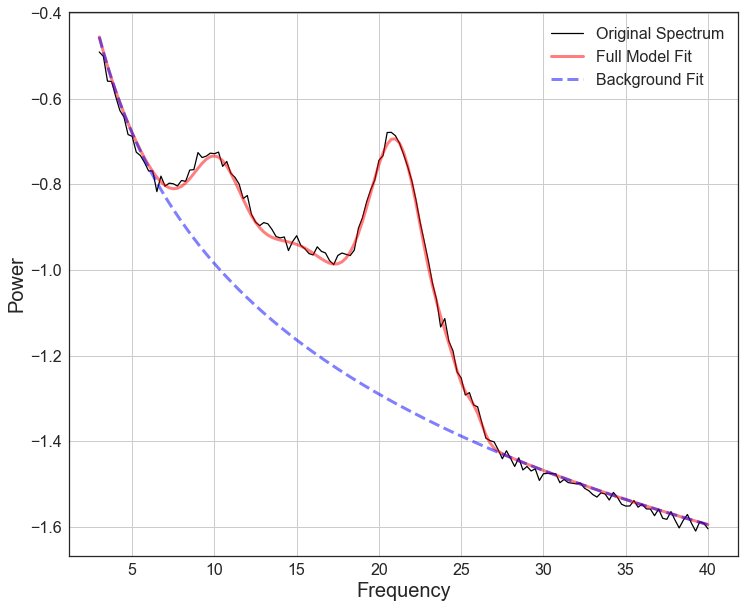

In [115]:
# Grab example case
ind = 1
fm = fgs[-1].get_fooof(ind, True)
print(syn_params[-1][ind])
fm.print_results()
fm.plot()

## Tests

In [ ]:
## Tests

from random import choice

def im_a_generator(params):
    while True:
        yield choice(params)
        
def im_callable(params):
    return choice(params)
    #return params[np.random.randint(len(params))]

def test_call(call_me):
    print(im_callable([1, 2, 3]))
    
test_call(im_callable)